In [23]:
%matplotlib inline
from PIL import Image
import numpy
import os
import re
import random
from resizeimage import resizeimage
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.decomposition import PCA
import copy
import matplotlib.image as mpimg
from sklearn.decomposition import RandomizedPCA

In [24]:
import collections
# resize images
def resizeImagesToDest(source, dest, prefix, height, noiseAlgo=None):    
    for root, dirs, files in os.walk(source):
        for name in files:
            if re.match(r'^'+prefix+'.*gif$', name, re.I):
                img = Image.open(os.path.join(source, name))
                (origWidth, origHeight) = img.size
                if (height == origHeight):
                    resizedImg = img
                else:
                    resizedImg = resizeimage.resize_height(img, height)
                
                (width, height) = resizedImg.size
                if noiseAlgo:
                    noisyImg = noiseAlgo(numpy.asarray(resizedImg))
                    Image.fromarray(numpy.uint8(noisyImg.reshape(height,width))).save(dest+name)
                else:
                    resizedImg.save(dest+name)

def resizeImages(source, prefix):
    resizeImagesToDest(source, 'yalefaces_resized/', prefix, 50)
                
# images into array: http://stackoverflow.com/questions/13550376/pil-image-to-array-numpy-array-to-array-python
def readImagesIntoMatrix(path, prefix):
    images = None
    groups = collections.defaultdict(set)
    grouptag = {}
    i = 0
    for root, dirs, files in os.walk(path):
        for name in files:
            if re.match(r'^'+prefix+'.*gif$', name, re.I):
                img = Image.open(path + name)                
                (width, height) = img.size
                imgArr = numpy.asarray(img).reshape(height * width)
                if images is not None:
                    images = numpy.vstack([images, imgArr])
                else:
                    images = imgArr
                group = re.match(r'.*yaleB([0-9]+)_.*', name, re.I).group(1)
                groups[group].add(i)
                grouptag[i] = group
                i += 1
    return images, groups, grouptag

def saveImages(path, images, width, height):
    for i in range(0, len(images)):
        Image.fromarray(numpy.uint8(images[i]).reshape(height, width)).save(path+str(i)+'.gif')
        
def addGaussianNoise(image):
    noisyImage = copy.deepcopy(image)
    mu = noisyImage.mean()
    std = noisyImage.std()
    noise = 0.2 * numpy.random.normal(mu, std, noisyImage.shape)
    for i in range(len(image)):
        for j in range(len(image[0])):
            val = image[i][j]
            if val + noise[i][j] >= 255:
                noisyImage[i][j] = 255
            elif val + noise[i][j] <= 0:
                noisyImage[i][j] = 0
            else:
                noisyImage[i][j] = val + noise[i][j] 
    
    return noisyImage  
    
def addSparseNoise(image):
    noisyImage = copy.deepcopy(image)
    for i in range(len(image)):
        for j in range(len(image[0])):
            rand = random.random()
            if (rand <= 0.01):
                noisyImage[i][j] = 0
    
    return noisyImage

In [25]:
resizeImages('yalefaces/', 'yale.*')
imageList, groups, grouptag = readImagesIntoMatrix('yalefaces_resized/', '.*')
imageList = imageList.T

print("Images %s" % imageList)

Image.fromarray(numpy.uint8(imageList.T[0].reshape(50,44))).save("secondyaletest/testsaveimage1.gif")
Image.fromarray(numpy.uint8(imageList.T[100].reshape(50,44))).save("secondyaletest/testsaveimage100.gif")

Images [[155   4 135 ..., 161  84   5]
 [152   4 135 ..., 162  84   5]
 [136   4 120 ..., 166  88   5]
 ..., 
 [ 11 145   6 ...,   6   4 163]
 [ 11 141   6 ...,   6   6 178]
 [ 12 136   7 ...,  13   8 187]]


In [26]:
(width, height) = 44, 50
# average Image
#print('Num images %s' % (imageList.shape,))
avgImg = imageList.mean(axis=1)
print('Average image %s' % (avgImg))
normalizedImageList = imageList - avgImg.reshape(width*height,1)*numpy.ones((1,len(imageList.T)))
Image.fromarray(numpy.uint8(avgImg.reshape(height,width))).save('secondyaletest/avgImg.gif')

Average image [ 59.02526926  62.63835957  64.9908865  ...,  49.28583264  46.52734051
  40.11267606]


In [27]:
def normalize_face(vector):
    minValue = numpy.amin(vector)
    maxValue = numpy.amax(vector)
    scale = (255./(maxValue-minValue))
    return (vector - minValue)*scale

# Fit with PCA for 90% of variance
pca = PCA(0.9).fit_transform(normalizedImageList)
print('With PCA there were %s eigenfaces that captures 90pct of the variance' % len(pca.T))

for i in range(len(pca.T)):
    eigv = pca[:,i].reshape(1,width * height).T
    eigenface = normalize_face(eigv)
    Image.fromarray(numpy.uint8(eigenface.reshape(height,width))).save('secondyaletest/trial3-eigenface%s.gif' % i)

With PCA there were 33 eigenfaces that captures 90pct of the variance


In [28]:
from numpy.linalg import norm, svd
from scipy.io import loadmat, savemat

def inexact_augmented_lagrange_multiplier(X, lmbda=.01, tol=1e-3,
                                          maxiter=100, verbose=True):
    """
    Inexact Augmented Lagrange Multiplier
    """
    Y = X
    norm_two = norm(Y.ravel(), 2)
    norm_inf = norm(Y.ravel(), numpy.inf) / lmbda
    dual_norm = numpy.max([norm_two, norm_inf])
    Y = Y / dual_norm
    A = numpy.zeros(Y.shape)
    E = numpy.zeros(Y.shape)
    dnorm = norm(X, 'fro')
    mu = 1.25 / norm_two
    rho = 1.5
    sv = 10.
    n = Y.shape[0]
    itr = 0
    while True:
        if verbose:
            print('Iterations %s' % itr)
        Eraw = X - A + (1 / mu) * Y
        Eupdate = numpy.maximum(Eraw - lmbda / mu, 0) + numpy.minimum(Eraw + lmbda / mu, 0)
        U, S, V = svd(X - Eupdate + (1 / mu) * Y, full_matrices=False)
        svp = (S > 1 / mu).shape[0]
        if svp < sv:
            sv = numpy.min([svp + 1, n])
        else:
            sv = numpy.min([svp + round(.05 * n), n])
        Aupdate = numpy.dot(numpy.dot(U[:, :svp], numpy.diag(S[:svp] - 1 / mu)), V[:svp, :])
        A = Aupdate
        E = Eupdate
        Z = X - A - E
        Y = Y + mu * Z
        mu = numpy.min([mu * rho, mu * 1e7])
        itr += 1
        if ((norm(Z, 'fro') / dnorm) < tol) or (itr >= maxiter):
            break
    if verbose:
        print("Finished at iteration %d" % (itr))  
    return A,E

In [29]:
A, E = inexact_augmented_lagrange_multiplier(normalizedImageList)

Iterations 0
Iterations 1
Iterations 2
Iterations 3
Iterations 4
Iterations 5
Iterations 6
Iterations 7
Iterations 8
Iterations 9
Iterations 10
Iterations 11
Iterations 12
Iterations 13
Iterations 14
Iterations 15
Iterations 16
Iterations 17
Iterations 18
Iterations 19
Iterations 20
Iterations 21
Iterations 22
Iterations 23
Iterations 24
Iterations 25
Iterations 26
Iterations 27
Iterations 28
Finished at iteration 29


In [30]:
Image.fromarray(numpy.uint8((A.T[0] + avgImg).reshape(50,44))).save("secondyaletest/testsaveimage1afterrpca.gif")

print('Error %s' % E)

print('Relative error %s' % (numpy.linalg.norm(E, 'fro')/numpy.linalg.norm(normalizedImageList, 'fro')))

Error [[ 29.47154864   1.38587638  52.26933902 ...,  27.94830662  -7.23200304
   -1.71289954]
 [ 26.59521867   1.68307986  48.22074076 ...,  25.5982466   -7.22357765
   -2.48747389]
 [ 12.79967237   0.39494452  31.90784184 ...,  30.23312859  -1.76243837
   -3.45600502]
 ..., 
 [  0.57668763  21.04121044  -4.57883251 ...,  -3.64121018  -3.39215507
   53.56857782]
 [ -0.34770782  23.64493797  -5.53346484 ...,  -2.79193018  -2.10040627
   71.45596794]
 [  0.81938153  37.3198014   -4.88200021 ...,   3.73356815  -0.67882753
   96.40086592]]
Relative error 0.392533270456


In [31]:

# Fit with PCA for 90% of variance
rpca = PCA(0.9).fit_transform(A)

print('After RPCA there were %s eigenfaces that captures 90pct of the variance' % len(rpca.T))

#Let's make images for the same number of eigenfaces we used originally
rpca = PCA(len(pca.T)).fit_transform(A)

for i in range(len(rpca.T)):
    eigv = rpca[:,i].reshape(1,width * height).T
    eigenface = normalize_face(eigv)
    Image.fromarray(numpy.uint8(eigenface.reshape(height,width))).save('secondyaletest/rpca-trial3-eigenface%s.gif' % i)

After RPCA there were 3 eigenfaces that captures 90pct of the variance


In the original dimension silhouette is -0.0974298504478
Clustering silhouette over PCA [-0.19753669842168189, -0.17066491183652976, -0.16088539965234078, -0.14577541538113975, -0.14415008945296612, -0.13795632258320228, -0.13683455158100699, -0.13229127863072032, -0.12641551355228386, -0.12381329064028451, -0.12108989212419041, -0.11833112450583616, -0.11698900120580537, -0.11593001447145851, -0.11395334988920588, -0.11227438981984185, -0.1115109207102751, -0.11130841055064987, -0.1103977319838088, -0.10929927288129292, -0.10879356810202361, -0.10858304930769234, -0.10763793105946519, -0.10733275767970181, -0.10701140274652848, -0.10697029277585797, -0.10637254139051787, -0.10611057396279017, -0.1056754708139476, -0.10493172857948134, -0.10464796669760114, -0.10445759586922349, -0.10416256456547356]


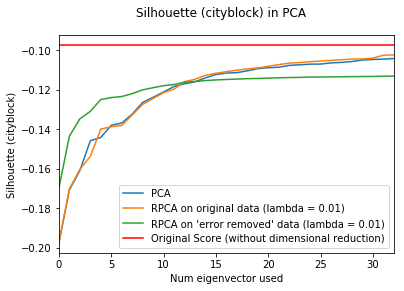

In the original dimension silhouette is -0.0976143895142
Clustering silhouette over PCA [-0.19753669842168189, -0.17066491183652976, -0.16088539965234078, -0.14577541538113975, -0.14415008945296612, -0.13795632258320228, -0.13683455158100699, -0.13229127863072032, -0.12641551355228386, -0.12381329064028451, -0.12108989212419041, -0.11833112450583616, -0.11698900120580537, -0.11593001447145851, -0.11395334988920588, -0.11227438981984185, -0.1115109207102751, -0.11130841055064987, -0.1103977319838088, -0.10929927288129292, -0.10879356810202361, -0.10858304930769234, -0.10763793105946519, -0.10733275767970181, -0.10701140274652848, -0.10697029277585797, -0.10637254139051787, -0.10611057396279017, -0.1056754708139476, -0.10493172857948134, -0.10464796669760114, -0.10445759586922349, -0.10416256456547356]


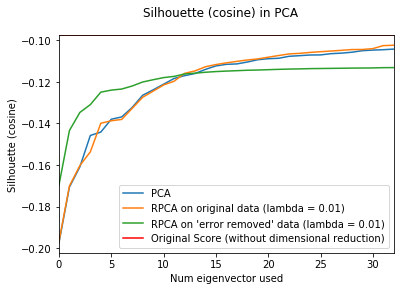

In the original dimension silhouette is -0.0840721366793
Clustering silhouette over PCA [-0.19753669842168189, -0.17066491183652976, -0.16088539965234078, -0.14577541538113975, -0.14415008945296612, -0.13795632258320228, -0.13683455158100699, -0.13229127863072032, -0.12641551355228386, -0.12381329064028451, -0.12108989212419041, -0.11833112450583616, -0.11698900120580537, -0.11593001447145851, -0.11395334988920588, -0.11227438981984185, -0.1115109207102751, -0.11130841055064987, -0.1103977319838088, -0.10929927288129292, -0.10879356810202361, -0.10858304930769234, -0.10763793105946519, -0.10733275767970181, -0.10701140274652848, -0.10697029277585797, -0.10637254139051787, -0.10611057396279017, -0.1056754708139476, -0.10493172857948134, -0.10464796669760114, -0.10445759586922349, -0.10416256456547356]


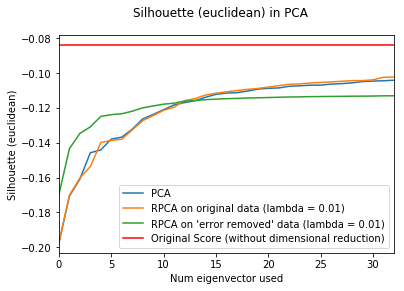

In [32]:
xdata = [0.0]*len(pca.T)
ydata = [0.0]*len(pca.T)
ydataRPCA = [0.0]*len(pca.T)
ydataRPCAOnReduced = [0.0]*len(pca.T)

from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score

pca_normalized = normalize(pca, axis=0, norm='l2')
rpca_normalized = normalize(rpca, axis=0, norm='l2')

def in_group_distance(projections, i):
    group = grouptag[i]
    distance = 0
    for j in groups[group]:
        if i != j:
            distance += numpy.linalg.norm(projections[i] - projections[j], 2)
    return distance/(len(groups[group]) - 1)

def min_out_group_distance(projections, i):
    group = grouptag[i]
    min_distance = float('inf')
    for group2 in groups:
        if group2 != group:
            distance = 0
            for j in groups[group2]:
                distance += numpy.linalg.norm(projections[i] - projections[j], 2)
            distance /= len(groups[group2])
            if distance <= min_distance:
                min_distance = distance
    return min_distance

def object_sillhouette(projections, i):
    a = in_group_distance(projections, i)
    b = min_out_group_distance(projections, i)
    return (b-a)/(max(a,b))
    

def group_sillhouette(projections, group):
    total = 0.0
    for i in groups[group]:
        total += object_sillhouette(projections, i)
    return total / (len(groups[group]))

def clustering_sillhouette(projections):
    total = 0.0
    for group in groups:
        print ('On group %s' % group)
        total += group_sillhouette(projections, group)
    return total / (len(groups))

grouptagarray = [""]*len(grouptag)
for i in range(len(grouptag)):
    grouptagarray[i] = grouptag[i]

for metric in ['cityblock', 'cosine', 'euclidean']:
    original_clustering = silhouette_score(normalizedImageList.T, grouptagarray, metric=metric)
    print('In the original dimension silhouette is %s' % original_clustering)

    for i in range(len(pca.T)):
      xdata[i] = i
      projected = normalizedImageList.T.dot(pca_normalized[:,:i+1])
      ydata[i] = silhouette_score(projected, grouptagarray)
      projectedRPCA = normalizedImageList.T.dot(rpca_normalized[:,:i+1])
      ydataRPCA[i] = silhouette_score(projectedRPCA, grouptagarray)
      projectedRPCAOnReduced = A.T.dot(rpca_normalized[:,:i+1])
      ydataRPCAOnReduced[i] = silhouette_score(projectedRPCAOnReduced, grouptagarray)

    print('Clustering silhouette over PCA %s' % ydata)

    fig = plt.figure()
    fig.suptitle("Silhouette (%s) in PCA" % metric)
    plt.plot(xdata, ydata, label="PCA")
    plt.plot(xdata, ydataRPCA, label="RPCA on original data (lambda = 0.01)")
    plt.plot(xdata, ydataRPCAOnReduced, label="RPCA on 'error removed' data (lambda = 0.01)")
    plt.axhline(y=original_clustering, color='r', linestyle='-', label='Original Score (without dimensional reduction)')
    plt.xlabel("Num eigenvector used")
    plt.ylabel("Silhouette (%s)" % metric)
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.legend()
    plt.savefig("figures/rpca0dot1trial1%s.png" % metric, format = 'png')
    plt.show()
    plt.close()


In [11]:
imagesH = None
rpcaImagesH = None

count = 0
for i in groups["24"]:
    if count > 5:
        break
    if imagesH is None:
        imagesH = imageList.T[i].reshape(50,44)
    else:
        imagesH = numpy.hstack([imagesH, imageList.T[i].reshape(50,44)])
    if rpcaImagesH is None:
        rpcaImagesH = (A.T[i] + avgImg).reshape(50,44)
    else:
        rpcaImagesH = numpy.hstack([rpcaImagesH, (A.T[i] + avgImg).reshape(50,44)])
    count += 1
    
Image.fromarray(numpy.uint8(imagesH)).save("figures/person24trial3.gif")
Image.fromarray(numpy.uint8(rpcaImagesH)).save("figures/person24AfterRPCAtrial3.gif")

In [12]:
print('Num groups %s' % len(groups))

Num groups 38
